In [1]:
import src.extrae_letras_toolbox as etb
from src.img_toolbox import resize_to_fit

import pickle
import cv2
import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt


In [2]:
# Cargar Labels Entrenadas
labels_filename = "model_labels.dat"

with open(labels_filename, "rb") as f:
    labels = pickle.load(f)

In [3]:
# Cargar el Modelo Entrenado
model_filename = "captcha_model.hdf5"

model = load_model(model_filename)


In [11]:
# Cargar la Imagen de un Captcha
test_files = ["1BCS.png", "8J90.png", "CN8Z.png", "DXOJ.png", "EZHQ.png", "LMQS.png", "ME1Q.png", "P6J9.png", "PDH4.png", "SHSW.png", "T52Q.png", "VIBK.png"]

#image_filename = "input/captchas_dataset/test_data/EZHQ.png"
#image_filename = "input/captchas_dataset/test_data/DXOJ.png"
#image_filename = "input/captchas_dataset/test_data/SHSW.png"
#image_filename = "input/captchas_dataset/test_data/PDH4.png"
#image_filename = "input/captchas_dataset/test_data/1BCS.png"
image_filename = "input/captchas_dataset/test_data/8J90.png"


image = etb.get_image(image_filename)


In [12]:
# Hago las mismas transformaciones en la imagen que en el script `extraer_letras.py`:
image_bnw = etb.image_to_bnw(image.copy())
smoothed_image = etb.smoothing_median_blur(image_bnw)
thresholded_image = etb.image_thresholding(smoothed_image)


In [13]:
# Saco los contornos de la imagen letra
contours = etb.get_contours(thresholded_image)


In [14]:
# Del contorno extraigo la región (el rectángulo que envuelve cada letra)
regions = etb.get_regions(contours)


In [15]:
# Estamos tratando captchas de 4 letras.
# Si recibimos menos de 4 regiones seguramente se han juntado varias letras en una sola región que hay que dividir.
while len(regions) < 4:
    largest_region = etb.get_largest_region_by_area_size(regions)
    new_regions = etb.divide_region_by_width(largest_region)
    regions += new_regions
    regions.remove(largest_region)


['8', 'J', '9', 'O']


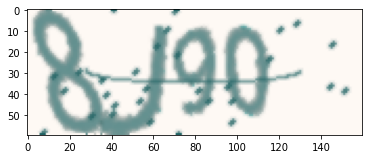

In [16]:
predictions = []

# Las regiones están ordenadas por la coordenada X (la de la izquierda contienen la primera letra)
# Recorro todas esas regiones (deberían ser 4 regiones tras el paso anterior).
for region in etb.get_sorted_regions_by_coord_x(regions):
    x, y, w, h = region
    
    # Corto una región que contiene una letra
    letter_image = image_bnw[y:y + h, x:x + w]

    # Redimensiono la región a 20x20 pixels (igual que los datos de entrenamiento)
    letter_image = resize_to_fit(letter_image, 20, 20)

    # Convierto cada imagen de letra en una lista de 4 dimensiones. Sin esto Keras no funciona.
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)

    # Uso el modelo para hacer predicciones
    prediction = model.predict(letter_image)

    # Con la predicción busco en las labels (que codifiqué en one-hot-encoding) a que letra corresponde
    letter = labels.inverse_transform(prediction)[0]
    predictions.append(letter)

# Muestro la imagen (el captcha)
plt.imshow(image, cmap='Greys')

# Muestro la predicción
print(predictions)